In [ ]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np  
import zipfile
import io
import matplotlib.pyplot as plt
import os

url='https://api.iea.org/evs?parameters=EV%20stock%20share&category=Historical&mode=Cars&csv=true'
response = requests.get(url)
evshare_df = pd.read_csv(url)

co2_df = pd.read_csv("https://ourworldindata.org/grapher/co-emissions-per-capita.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
metadata = requests.get("https://ourworldindata.org/grapher/co-emissions-per-capita.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

#Filter the data for EV stock share
evstock_filter = evshare_df['parameter'] == 'EV stock share'
ev_filter = evshare_df['powertrain'] == 'EV'
evshare_filtered = evshare_df[evstock_filter & ev_filter]

#Clean the data
evshare_filtered = evshare_filtered.dropna()
evshare_filtered = evshare_filtered.drop(columns=["mode", "unit", "category", "parameter", "powertrain"])
co2_df = co2_df.dropna()
co2_df = co2_df.drop(columns=["Code"])

#Rename columns
evshare_filtered = evshare_filtered.rename(columns={
    'region': 'Entity',
    'year': 'Year',
    'value': 'Share of EVs (%)',
})
co2_df = co2_df.rename(columns={
    'Entity': 'Entity',
    'Year': 'Year',
    'emissions_total_per_capita': 'CO2 Emissions per Capita (tonnes/person)',
})

#Indexing and renaming columns
evshare_index = evshare_filtered.set_index(['Entity', 'Year'])
co2_index = co2_df.set_index(['Entity', 'Year'])

# Merge the two dataframes on Entity and Year
merged_df = evshare_index.merge(co2_index, on=['Entity', 'Year'], how='inner')

# Reset index to make it easier to work with
merged_df = merged_df.reset_index()

# Save the merged dataframe to a CSV file
merged_df.to_csv('ev_co2_data.csv', index=False)

#Descriptive statistics
merged_df['Share of EVs (%)'] = pd.to_numeric(merged_df['Share of EVs (%)'], errors='coerce')
merged_df['CO2 Emissions per Capita (tonnes/person)'] = pd.to_numeric(merged_df['CO2 Emissions per Capita (tonnes/person)'], errors='coerce')

descriptive_stats = merged_df[['Share of EVs (%)', 'CO2 Emissions per Capita (tonnes/person)']].describe()
print("Descriptive Statistics for EV Share and CO2 Emissions:")
print(descriptive_stats)


Descriptive Statistics for EV Share and CO2 Emissions:
       Share of EVs (%)  CO2 Emissions per Capita (tonnes/person)
count        450.000000                                450.000000
mean           1.074363                                  6.825161
std            2.990492                                  3.356382
min            0.000021                                  1.344883
25%            0.014000                                  4.532007
50%            0.089000                                  6.715328
75%            0.620000                                  8.481037
max           30.000000                                 17.965439


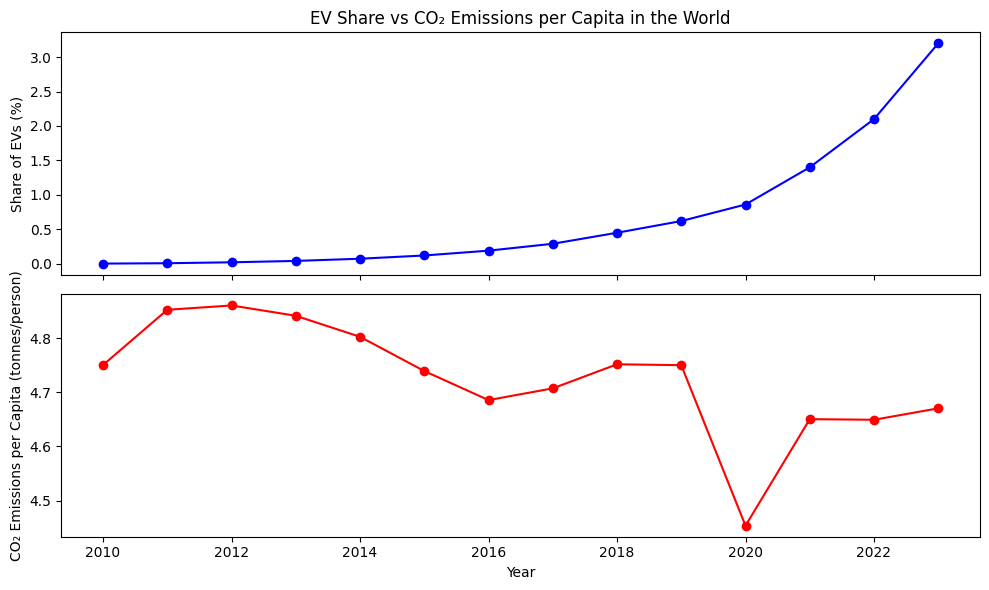

In [25]:
# Plotting the data
country = 'World'
df_country = merged_df[merged_df['Entity'] == country]

# Extract time series
years = df_country['Year']
ev_share = df_country['Share of EVs (%)']
ghg_emissions = df_country['CO2 Emissions per Capita (tonnes/person)']

# Plot as stacked subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

ax1.plot(years, ev_share, color='blue', marker='o')
ax1.set_ylabel('Share of EVs (%)')
ax1.set_title(f'EV Share vs CO₂ Emissions per Capita in the {country}')

ax2.plot(years, ghg_emissions, color='red', marker='o')
ax2.set_ylabel('CO₂ Emissions per Capita (tonnes/person)')
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

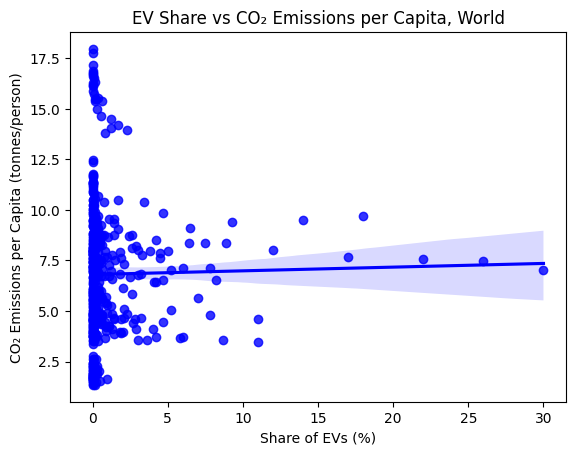

In [35]:
sns.regplot(x='Share of EVs (%)', y='CO2 Emissions per Capita (tonnes/person)', data=merged_df, color='blue')
plt.title('EV Share vs CO₂ Emissions per Capita, World')
plt.xlabel('Share of EVs (%)')
plt.ylabel('CO₂ Emissions per Capita (tonnes/person)')
plt.show()


In [14]:
import statsmodels.api as sm

X = merged_df['Share of EVs (%)']
y = merged_df['CO2 Emissions per Capita (tonnes/person)']
X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                                       OLS Regression Results                                       
Dep. Variable:     CO2 Emissions per Capita (tonnes/person)   R-squared:                       0.000
Model:                                                  OLS   Adj. R-squared:                 -0.002
Method:                                       Least Squares   F-statistic:                    0.1192
Date:                                      Sun, 01 Jun 2025   Prob (F-statistic):              0.730
Time:                                              00:17:42   Log-Likelihood:                -1182.9
No. Observations:                                       450   AIC:                             2370.
Df Residuals:                                           448   BIC:                             2378.
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

In [15]:
import statsmodels.api as sm
import pandas as pd

# Prepare a list to store results
results = []

# Loop through each country
for country in merged_df['Entity'].unique():
    country_df = merged_df[merged_df['Entity'] == country]

    # Only run regression if there are enough data points
    if len(country_df) < 5:
        continue

    X = country_df['Share of EVs (%)']
    y = country_df['CO2 Emissions per Capita (tonnes/person)']
    
    # Skip if either variable is constant
    if X.nunique() <= 1 or y.nunique() <= 1:
        continue

    # Add constant (intercept)
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()

    results.append({
        'Country': country,
        'Coef_EV_share': model.params['Share of EVs (%)'],
        'P_value': model.pvalues['Share of EVs (%)'],
        'R_squared': model.rsquared,
        'N_obs': len(country_df)
    })

# Convert results to a DataFrame
country_results_df = pd.DataFrame(results)

# Save to CSV (optional)
country_results_df.to_csv('ev_co2_country_ols_results.csv', index=False)

# Show top countries with strongest relationship (sorted by p-value)
print(country_results_df.sort_values(by='P_value').head(10))


         Country  Coef_EV_share       P_value  R_squared  N_obs
24        Norway      -0.062362  1.239065e-08   0.938623     14
22   Netherlands      -0.462986  1.871509e-07   0.903759     14
23   New Zealand      -0.809853  6.619715e-07   0.881414     14
19         Japan      -2.899983  8.807160e-06   0.818402     14
28  South Africa     -51.721921  1.466989e-05   0.887361     11
6          China       0.201088  4.130937e-05   0.766121     14
26      Portugal      -0.507477  4.835413e-05   0.760034     14
12       Germany      -0.542754  6.841403e-05   0.746070     14
1        Austria      -0.393952  9.126458e-05   0.733878     14
4         Canada      -1.051941  1.759453e-04   0.736004     13
